In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [35]:
%reload_ext autoreload
%autoreload 2
from rnn import MyGRU, MyLSTM, VanillaRNN, RNN
# Download the downsampled data frame from csv-file.
raw_data = pd.read_csv(r'data_example_offsets_new.csv')
raw_data_offsets_removed = raw_data.copy();
raw_data_offsets_removed['Radiator_network_2_temperature'] -= raw_data_offsets_removed['Radiator_network_2_offset']
raw_data_offsets_removed['Ventilation_network_2_temperature'] -= raw_data_offsets_removed['Ventilation_network_2_offset']

seq = 12  # Model input sequence length
fut = 1  # Time of prediction relative to end of model input sequence

# Initialize the model with the required parameters.
hvac_model = MyGRU(y_parameters=['Energy_consumption'], seq=seq, fut=fut, x_parameters=[
    'Outside_humidity',
    'Solar_irradiance',
    'CO2_concentration',
    'hours_sin',
    'hours_cos',
    'weekday_sin',
    'weekday_cos',
    'Domestic_water_network_1_primary_valve',
    'Domestic_water_network_2_primary_valve',
    'District_heat_temperature',
    'Outside_temperature_average',
    'Ventilation_network_1_temperature',
    'Ventilation_network_2_temperature',
    'Radiator_network_1_temperature',
    'Radiator_network_2_temperature'
])

# Scale and split data frame.
df_train, x_train, y_train, df_val, x_val, y_val = hvac_model.preprocess(raw_data)
df_train_offsets_removed, x_train_offsets_removed, y_train_offsets_removed, df_val_offsets_removed, x_val_offsets_removed, y_val_offsets_removed = hvac_model.preprocess(raw_data_offsets_removed, False)

# Extract dates for predictions
pred_dates_train = hvac_model.get_pred_dates(df_train)
pred_dates_val = hvac_model.get_pred_dates(df_val)


Shape of training data: x: (1544, 12, 15) y: (1544, 1)
Shape of testing data: x: (376, 12, 15) y: (376, 1)
Shape of training data: x: (1544, 12, 15) y: (1544, 1)
Shape of testing data: x: (376, 12, 15) y: (376, 1)


In [36]:
#hvac_model.load(r'GRU_Energy_consumption_2022-06-14_trained_fut_0')
hvac_model.load(r'GRU_Energy_consumption_2022-06-15_trained_fut_1')
print(hvac_model.fut)

Model loaded.
Scaler loaded.
Other variables loaded.
1


In [50]:
def print_metrics(y, y_hat):
  print("Bias")
  print(np.mean(y_hat - y))
  print("MSE")
  print(np.mean((y_hat - y)**2))
  print("RMSE")
  print(np.sqrt(np.mean((y_hat - y)**2)))
  print("MAE")
  print(np.mean(np.abs(y_hat - y)))
  print("MAPE")
  print(str(100*np.mean(np.abs((y_hat - y)/y))) + " %")
  
print("Training dataset")
y_hat, y = hvac_model.inv_target(x_train, hvac_model.model.predict(x_train), y_train)
print_metrics(y_hat, y)

print("\nTesting dataset")
y_hat, y = hvac_model.inv_target(x_val, hvac_model.model.predict(x_val), y_val)
print_metrics(y_hat, y)


Training dataset
49/49 [==============================] - 0s 1ms/step
Bias
0.0045476986669634985
MSE
334.4185515126943
RMSE
18.287114357183157
MAE
13.594812066938458
MAPE
6.94903322563684 %

Testing dataset
12/12 [==============================] - 0s 760us/step
Bias
0.6237120133765455
MSE
1602.1712464796678
RMSE
40.02713137959886
MAE
28.194633859427686
MAPE
7.783641064920095 %


49/49 [==============================] - 0s 1ms/step


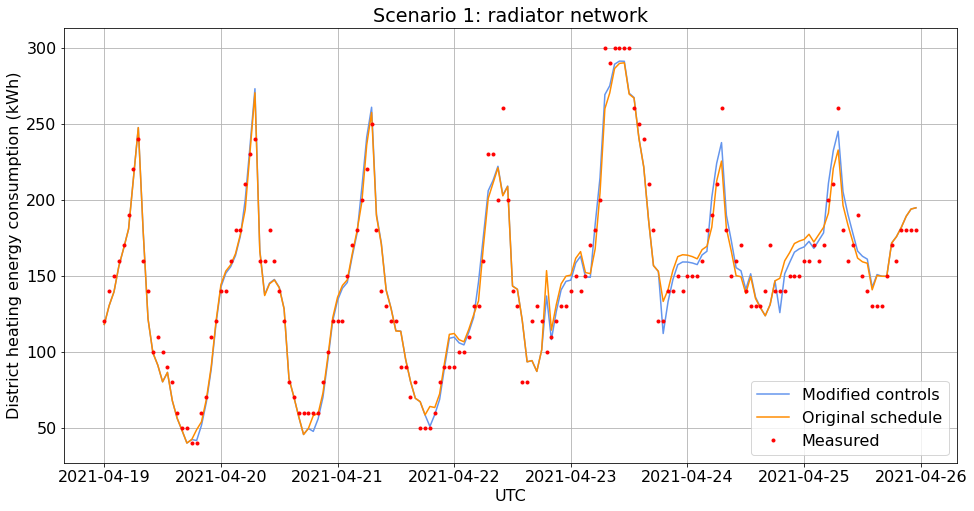

How many hours into the future is the prediction:
1
Relative change in energy consumption for full week:
-0.00030180708658424603
Relative change in energy consumption for 24 hours covering last scenario:
0.0014914429916074528


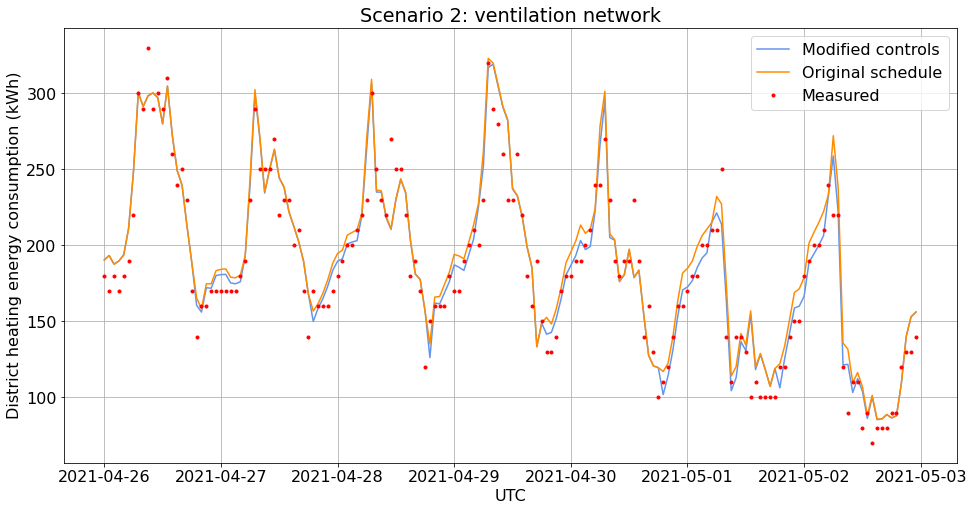

How many hours into the future is the prediction:
1
Relative change in energy consumption for full week:
-0.02162963283601118
Relative change in energy consumption for 24 hours covering last scenario:
-0.05080063680260406


In [27]:
# Scenario predictions using a single trained model
preds, y_scenario = hvac_model.inv_target(x_train, hvac_model.model.predict(x_train), y_train)
preds_offsets_removed, y_offsets_removed = hvac_model.inv_target(x_train_offsets_removed, hvac_model.model.predict(x_train_offsets_removed), y_train_offsets_removed)

plt.rcParams.update({'font.size': 16})

def plot_scenario_predictions(start, scenario):
  eval_start = start + 5*24 + 12
  eval_end = eval_start + 24
  plt.figure(figsize=(16, 8))
  plt.plot(pred_dates_train[start:start+24*7], preds[start:start+24*7], label="Modified controls", color="cornflowerblue", marker="")
  plt.plot(pred_dates_train[start:start+24*7], preds_offsets_removed[start:start+24*7], label="Original schedule", color="darkorange", marker="")
  plt.plot(pred_dates_train[start:start+24*7], y_scenario[start:start+24*7], label="Measured", color="red", marker=".", linestyle="")
  plt.title(scenario)
  plt.ylabel("District heating energy consumption (kWh)")
  plt.xlabel("UTC")
  plt.legend()
  plt.grid(True)
  plt.show()
  print ("How many hours into the future is the prediction:")
  print (hvac_model.fut)
  print ("Relative change in energy consumption for full week:")
  print ((np.sum(preds[start:start+24*7])-np.sum(preds_offsets_removed[start:start+24*7]))/np.sum(preds_offsets_removed[start:start+24*7]))
  print ("Relative change in energy consumption for 24 hours covering last scenario:")
  print ((np.sum(preds[eval_start:eval_end])-np.sum(preds_offsets_removed[eval_start:eval_end]))/np.sum(preds_offsets_removed[eval_start:eval_end]))

plot_scenario_predictions(1597-376-12-hvac_model.fut, "Scenario 1: radiator network")
plot_scenario_predictions(1597-376-12-hvac_model.fut + 24*7, "Scenario 2: ventilation network")


49/49 [==============================] - 0s 1ms/step


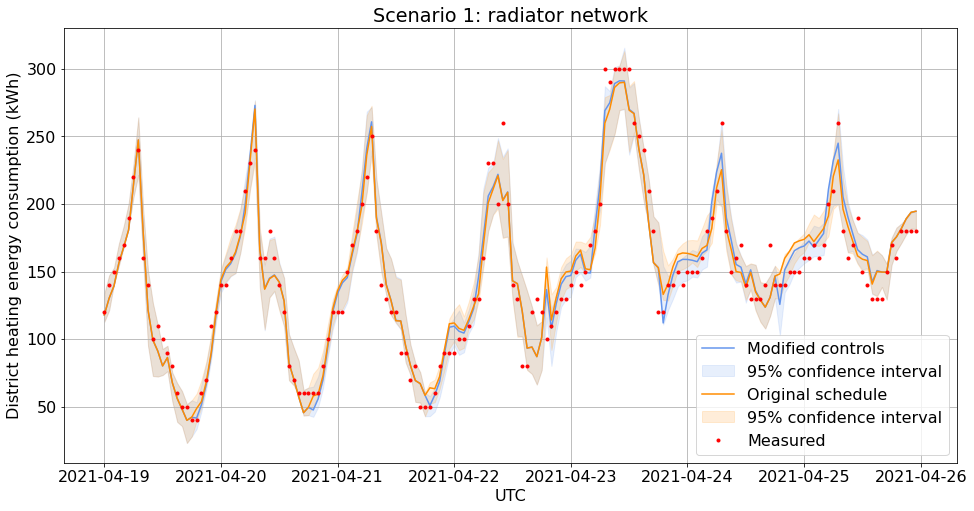

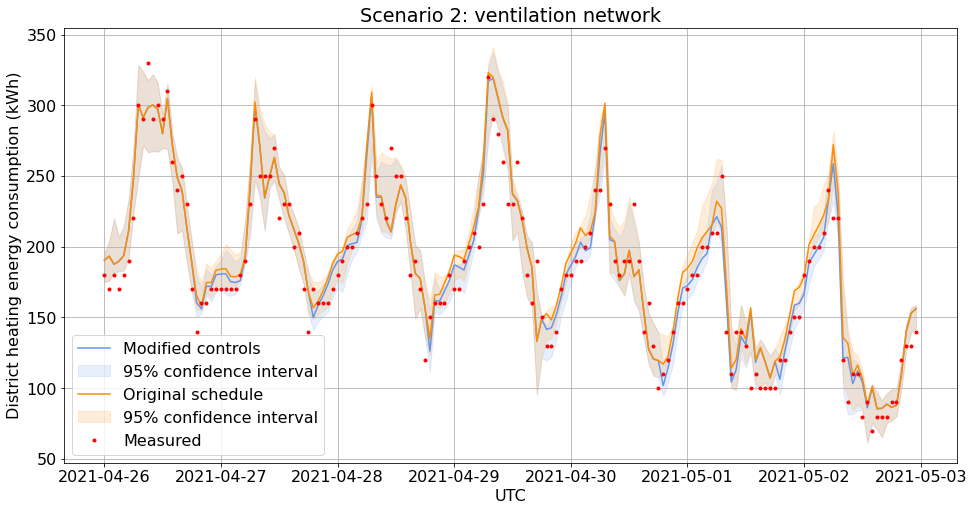

In [84]:
# Scenario predictions using a single trained model
preds, y_scenario = hvac_model.inv_target(x_train, hvac_model.model.predict(x_train), y_train)
preds_offsets_removed, y_offsets_removed = hvac_model.inv_target(x_train_offsets_removed, hvac_model.model.predict(x_train_offsets_removed), y_train_offsets_removed)

strResultsScenarioEnabled = np.loadtxt('predictedEnergyConsumptionScenarioEnabled.csv', dtype='str', delimiter=',')
strResultsScenarioDisabled = np.loadtxt('predictedEnergyConsumptionScenarioDisabled.csv', dtype='str', delimiter=',')

resultsScenarioEnabled = strResultsScenarioEnabled[:,1:].astype(np.float32).T
resultsScenarioDisabled = strResultsScenarioDisabled[:,1:].astype(np.float32).T

plt.rcParams.update({'font.size': 16})

def plot_scenario_predictions(start, scenario):
  eval_start = start + 5*24 + 12
  eval_end = eval_start + 24
  plt.figure(figsize=(16, 8))
  plt.plot(pred_dates_train[start:start+24*7], preds[start:start+24*7], label="Modified controls", color="cornflowerblue", marker="")
  plt.fill_between(pred_dates_train[start:start+24*7], resultsScenarioEnabled.min(axis=0)[start:start+24*7], resultsScenarioEnabled.max(axis=0)[start:start+24*7], color='cornflowerblue', alpha=0.15, label='95% confidence interval')
  plt.plot(pred_dates_train[start:start+24*7], preds_offsets_removed[start:start+24*7], label="Original schedule", color="darkorange", marker="")
  plt.fill_between(pred_dates_train[start:start+24*7], resultsScenarioDisabled.min(axis=0)[start:start+24*7], resultsScenarioDisabled.max(axis=0)[start:start+24*7], color='darkorange', alpha=0.15, label='95% confidence interval')
  plt.plot(pred_dates_train[start:start+24*7], y_scenario[start:start+24*7], label="Measured", color="red", marker=".", linestyle="")
  plt.title(scenario)
  plt.ylabel("District heating energy consumption (kWh)")
  plt.xlabel("UTC")
  plt.legend()
  plt.grid(True)
  plt.show()

plot_scenario_predictions(1597-376-12-hvac_model.fut, "Scenario 1: radiator network")
plot_scenario_predictions(1597-376-12-hvac_model.fut + 24*7, "Scenario 2: ventilation network")


49/49 [==============================] - 0s 895us/step


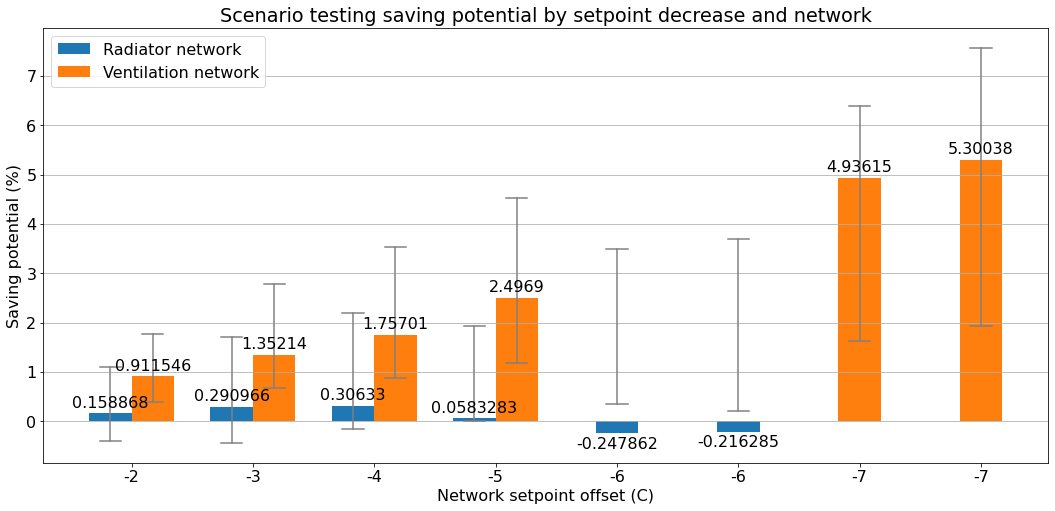

In [128]:
preds, y_scenario = hvac_model.inv_target(x_train, hvac_model.model.predict(x_train), y_train)
preds_offsets_removed, y_offsets_removed = hvac_model.inv_target(x_train_offsets_removed, hvac_model.model.predict(x_train_offsets_removed), y_train_offsets_removed)

def get_24h_reductions(start, days):
  reductions = []
  errors = []
  for i in range(len(days)):
    eval_start = start + days[i]*24 + 18
    eval_end = eval_start + 24
    reductions.append(-100*(np.sum(preds[eval_start:eval_end])-np.sum(preds_offsets_removed[eval_start:eval_end]))/np.sum(preds_offsets_removed[eval_start:eval_end]))
    ensemble_reductions = -100*(np.sum(resultsScenarioEnabled[:, eval_start:eval_end], axis=1) - np.sum(resultsScenarioDisabled[:, eval_start:eval_end], axis=1))/np.sum(resultsScenarioDisabled[:, eval_start:eval_end], axis=1)
    ensemble_min = ensemble_reductions.min()
    ensemble_max = ensemble_reductions.max()
    errors.append((ensemble_min, ensemble_max))
  return reductions, np.array(errors).T

fig, ax = plt.subplots(figsize=(18, 8))
width = 0.35
labels = [-2, -3, -4, -5, -6, -6, -7, -7]
x = np.arange(len(labels))  # the label locations
x_radiator = [0- width/2, 1- width/2, 2- width/2, 3- width/2, 4, 5]
reductions_radiator, errors_radiator = get_24h_reductions(1597-376-12-hvac_model.fut, [0, 1, 2, 3, 4, 5])
x_ventilation = [0+ width/2, 1+ width/2, 2+ width/2, 3+ width/2, 6, 7]
reductions_ventilation, errors_ventilation = get_24h_reductions(1597-376-12-hvac_model.fut + 24*7, [0, 1, 2, 3, 4, 5])
plt.grid(True, 'major', 'y')
rects1 = ax.bar(x_radiator, reductions_radiator, width, label='Radiator network')
rects2 = ax.bar(x_ventilation, reductions_ventilation, width, label='Ventilation network')
error_bar_color = "grey"
for i in range(len(x_radiator)):  
  plt.plot([x_radiator[i]-width/4, x_radiator[i]+width/4], [errors_radiator[0][i], errors_radiator[0][i]], color=error_bar_color, marker="")
  plt.plot([x_radiator[i]-width/4, x_radiator[i]+width/4], [errors_radiator[1][i], errors_radiator[1][i]], color=error_bar_color, marker="")
  plt.plot([x_radiator[i], x_radiator[i]], [errors_radiator[0][i], errors_radiator[1][i]], color=error_bar_color, marker="")
for i in range(len(x_ventilation)):
  plt.plot([x_ventilation[i]-width/4, x_ventilation[i]+width/4], [errors_ventilation[0][i], errors_ventilation[0][i]], color=error_bar_color, marker="")
  plt.plot([x_ventilation[i]-width/4, x_ventilation[i]+width/4], [errors_ventilation[1][i], errors_ventilation[1][i]], color=error_bar_color, marker="")
  plt.plot([x_ventilation[i], x_ventilation[i]], [errors_ventilation[0][i], errors_ventilation[1][i]], color=error_bar_color, marker="")
  
ax.set_xlabel('Network setpoint offset (C)')
ax.set_ylabel('Saving potential (%)')
ax.set_title('Scenario testing saving potential by setpoint decrease and network')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

plt.show()